In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss

import xgboost
import shap
shap.initjs()

In [2]:
df = pd.read_csv('soccer18.csv')

In [3]:
df.head()

,Div,Date,Y,HomeTeam,AwayTeam,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,home_xG,away_xG
0,EPL,2014-08-16,14,Arsenal,Crystal Palace,2,1,1,1,14,4,6,2,1.554110,0.158151
1,EPL,2014-08-16,14,Leicester,Everton,2,2,1,2,11,13,3,3,1.278300,0.613273
2,EPL,2014-08-16,14,Man United,Swansea,1,2,0,1,14,5,5,4,1.166350,0.278076
3,EPL,2014-08-16,14,QPR,Hull,0,1,0,0,19,11,6,4,1.900670,1.117570
4,EPL,2014-08-16,14,Stoke,Aston Villa,0,1,0,0,12,7,2,2,0.423368,0.909774


# Problem 1

## 1a

### i

In [4]:
# for unpivoting
df['game_id'] = df.index.values

value_vars = ['HomeTeam', 'AwayTeam']
id_vars = [i for i in df.columns.tolist() if i not in value_vars]

# unpivot data so that each row is one team for one game
melted = df.melt(id_vars=id_vars,
                 value_vars=value_vars, 
                 var_name='HomeOrAway', 
                 value_name='Team')
melted['isHomeTeam'] = melted['HomeOrAway'] == 'HomeTeam'

# filter out 2018 games
melted = melted[melted['Date'] < '2018-01-01']

# rename Evian Thonon Gaillard to Evian
melted['Team'] = np.where(melted['Team'] == 'Evian Thonon Gaillard', 'Evian', melted['Team'])

# compute goal differential for team
melted['GD'] = (melted['FTHG'] - melted['FTAG']) \
    * np.where(melted['isHomeTeam'], 1, -1)

# sort to ensure expanding window is correctly ordered
melted = melted.sort_values(['Team', 'Date'])

# calculate cumulative goal differential (inclusive)
melted['CGD'] = melted\
    .groupby('Team')\
    ['GD']\
    .expanding(min_periods=1,
               center=False)\
    .mean()\
    .reset_index()\
    .set_index('level_1')\
    ['GD']
# calculate number of games played (exclusive as it is 0-indexed)
melted['GameCount'] = melted\
    .groupby('Team')\
    .cumcount()

# lag values to avoid leakage
# no need to lag cumcount as it is 0-indexed
melted['LCGD'] = melted.groupby('Team')['CGD'].shift(1, fill_value=0)

In [5]:
# spot check first team by alphabet
melted[melted['Team'] == 'Ajaccio GFCO'].head(5)

,Div,Date,Y,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,...,home_xG,away_xG,game_id,HomeOrAway,Team,isHomeTeam,GD,CGD,GameCount,LCGD
14822,Ligue_1,2015-08-08,15,0,0,0,0,12,6,4,...,0.394458,1.059770,5692,AwayTeam,Ajaccio GFCO,False,0,0.000000,0,0.000000
14834,Ligue_1,2015-08-16,15,2,0,2,0,18,8,6,...,1.584010,0.150143,5704,AwayTeam,Ajaccio GFCO,False,-2,-1.000000,1,0.000000
5707,Ligue_1,2015-08-22,15,0,2,0,2,8,9,3,...,0.384935,1.156780,5707,HomeTeam,Ajaccio GFCO,True,-2,-1.333333,2,-1.000000
14849,Ligue_1,2015-08-29,15,1,0,1,0,13,12,5,...,0.756427,0.397943,5719,AwayTeam,Ajaccio GFCO,False,-1,-1.250000,3,-1.333333
5733,Ligue_1,2015-09-13,15,0,1,0,1,24,13,4,...,0.970684,2.982130,5733,HomeTeam,Ajaccio GFCO,True,-1,-1.200000,4,-1.250000


In [6]:
# spot check second team by alphabet
melted[melted['Team'] == 'Amiens'].head(5)

,Div,Date,Y,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,...,home_xG,away_xG,game_id,HomeOrAway,Team,isHomeTeam,GD,CGD,GameCount,LCGD
15579,Ligue_1,2017-08-05,17,2,0,1,0,16,7,5,...,2.252640,0.190301,6449,AwayTeam,Amiens,False,-2,-2.000000,0,0.000000
6457,Ligue_1,2017-08-12,17,0,2,0,1,10,12,1,...,0.705642,1.473760,6457,HomeTeam,Amiens,True,-2,-2.000000,1,-2.000000
15600,Ligue_1,2017-08-19,17,3,0,2,0,13,16,5,...,3.176240,1.069470,6470,AwayTeam,Amiens,False,-3,-2.333333,2,-2.000000
6476,Ligue_1,2017-08-26,17,3,0,2,0,12,12,4,...,1.329200,0.247748,6476,HomeTeam,Amiens,True,3,-1.000000,3,-2.333333
15620,Ligue_1,2017-09-09,17,0,1,0,1,10,8,3,...,0.599748,0.293267,6490,AwayTeam,Amiens,False,1,-0.600000,4,-1.000000


In [7]:
# pivot back to each row being a game
answer = melted.pivot(index=['Date', 'game_id', 'Div', 'Y'],
             columns=['HomeOrAway'],
             values=['LCGD', 'Team', 'GameCount'])

# compute absolute differential between historic averages
answer['absolute_differential'] = answer['LCGD']['AwayTeam'] - answer['LCGD']['HomeTeam']

# sort and display
answer.sort_values('absolute_differential', ascending=False).head(7)

LCGD                Team              \
HomeOrAway                     AwayTeam HomeTeam   AwayTeam    HomeTeam   
Date       game_id Div     Y                                              
2014-09-21 7214    Serie_A 14       1.0     -3.5  Sampdoria    Sassuolo   
2014-08-22 5326    Ligue_1 14       1.0     -3.5   Paris SG       Evian   
2017-08-13 6464    Ligue_1 17  0.078261     -4.0      Lille  Strasbourg   
2014-08-31 1912    La_Liga 14       1.0     -3.0    Granada       Elche   
2014-09-21 7212    Serie_A 14       3.5     -0.5      Inter     Palermo   
2014-08-30 1910    La_Liga 14       2.0     -2.0      Celta     Cordoba   
2014-09-13 7197    Serie_A 14       2.0     -2.0       Roma      Empoli   

                              GameCount          absolute_differential  
HomeOrAway                     AwayTeam HomeTeam                        
Date       game_id Div     Y                                            
2014-09-21 7214    Serie_A 14         2        2                   4.5  
2014-08-22 5326    Ligue_1 14         2        2                   4.5  
2017-08-13 6464    Ligue_1 17       115        1              4.078261  
2014-08-31 1912    La_Liga 14         1        1                   4.0  
2014-09-21 7212    Serie_A 14         2        2                   4.0  
2014-08-30 1910    La_Liga 14         1        1                   4.0  
2014-09-13 7197    Serie_A 14         1        1                   4.0

### ii

In [8]:
answer[(answer['GameCount']['AwayTeam'] >= 100) & (answer['GameCount']['HomeTeam'] >= 100)]\
    .sort_values('absolute_differential', ascending=False)\
    .head(7)

LCGD                     Team  \
HomeOrAway                        AwayTeam  HomeTeam       AwayTeam   
Date       game_id Div        Y                                       
2017-04-02 2940    La_Liga    16  2.192308    -0.875      Barcelona   
2017-05-06 3008    La_Liga    16       1.9 -0.936937    Real Madrid   
2017-03-12 2921    La_Liga    16   2.22549 -0.519608      Barcelona   
2017-04-29 2996    La_Liga    16  2.181818 -0.336364      Barcelona   
2017-10-21 4769    Bundesliga 17  1.872727 -0.609091  Bayern Munich   
2017-08-20 3043    La_Liga    17  1.938596 -0.517544    Real Madrid   
2017-04-26 2989    La_Liga    16  1.888889 -0.522936    Real Madrid   

                                            GameCount           \
HomeOrAway                         HomeTeam  AwayTeam HomeTeam   
Date       game_id Div        Y                                  
2017-04-02 2940    La_Liga    16    Granada       104      104   
2017-05-06 3008    La_Liga    16    Granada       110      111   
2017-03-12 2921    La_Liga    16  La Coruna       102      102   
2017-04-29 2996    La_Liga    16    Espanol       110      110   
2017-10-21 4769    Bundesliga 17    Hamburg       110      110   
2017-08-20 3043    La_Liga    17  La Coruna       114      114   
2017-04-26 2989    La_Liga    16  La Coruna       108      109   

                                 absolute_differential  
HomeOrAway                                              
Date       game_id Div        Y                         
2017-04-02 2940    La_Liga    16              3.067308  
2017-05-06 3008    La_Liga    16              2.836937  
2017-03-12 2921    La_Liga    16              2.745098  
2017-04-29 2996    La_Liga    16              2.518182  
2017-10-21 4769    Bundesliga 17              2.481818  
2017-08-20 3043    La_Liga    17               2.45614  
2017-04-26 2989    La_Liga    16              2.411825

### iii
The 2017 season game is unusual because it pitted Lille, which had 115 games played up until that point, against Strasbourg, which had only 1 game played before that and so must have been a new team. It is natural for most of the games with high average differentials to be in the earlier leagues, because the average is most likely to take on outlying values when the sample size of games played is low. In this case, a game from 2017 was able to make the list because Strasbourg was a new team and "achieved" an outlying differential in their first game. 

## 1b

In [9]:
df['HomeTeamWin'] = df['FTHG'] > df['FTAG']
train = df[df['Date'] < '2018-01-01']

X = np.ones_like(train['HomeTeamWin']).reshape(-1, 1)
y = train['HomeTeamWin']

lr = LogisticRegression(fit_intercept=False)\
    .fit(X=X, y=y)

lr.coef_

array([[-0.16781542]])

In [10]:
# calculate brier score
pred = lr.predict_proba(X)[:,1]
brier_score_loss(y, pred)

0.24824590314670295

## 1c
No, the intercept does not have to be positive. A game can result in a home team win, an away team win, or a draw. For the home team to be favored, the home team wins should be higher than the away team wins. For the intercept to be greater than 0, the home team wins must exceed the away team wins *and* the draws.

The target variable, whether the home team wins, has a natural occurrence rate of 45.84%; the rest are away team wins or draws. When we split the target variable into home team wins, away team wins, and draws, we see that home team winrate does exceed away team winrate as expected.

In [11]:
df['GD'] = df['FTHG'] - df['FTAG']
df['Outcome'] = np.where(df['GD'] > 0, 
                         'HomeTeamWin',
                         np.where(df['GD'] == 0, 'Draw',
                             'AwayTeamWin'))
df['Outcome'].value_counts()

HomeTeamWin    4165
AwayTeamWin    2678
Draw           2287
Name: Outcome, dtype: int64

## 1d

In [12]:
train_merged = pd.merge(left=train, 
         right=answer, 
         left_on='game_id', 
         right_on='game_id', 
         how='inner')

X = train_merged[[('LCGD', 'AwayTeam'), ('LCGD', 'HomeTeam')]]
X.columns = ['LCGD_AWAY', 'LCGD_HOME']

lr_with_lcgd = LogisticRegression()
lr_with_lcgd.fit(X=X, y=y)

lr_with_lcgd.coef_

merging between different levels can give an unintended result (1 levels on the left,2 on the right)


array([[-0.73361515,  0.78440468]])

In [13]:
pred = lr_with_lcgd.predict_proba(X)[:,1]
brier_score_loss(y, pred)

0.22094748510901424

# Problem 2: Bakeoff
With only 6400 training rows it's unlikely complex models or ensembles will be able to beat a simple logistic regression. Nonetheless since we have no concerns about model maintainability we can try out a large gamut of models and ensemble them together.

Since the `HS, AS, HST, AST, home_xG, away_xG` features are all only known or computed after the given game ends, we immediately lag them to avoid any possibility of leakage.

We will run transformations on all data since it's unlikely we'll be able to maintain performance on 2018 games with only 2017 data. Not a big fan of Pandas for these complex data transformations so I'll be using a PostgreSQL database. I use a software called dbt to run the SQL queries and document/test the resulting tables. 

## Computed features
Along with the lagged cumulative goal differential feature we calculated as part of the homework, I also calculated:
- difference between lagged cumulative shots-on-target / shots taken
- difference between lagged cumulative average shots taken
- difference between lagged cumulative win rate
- difference between win rate in previous matches between same team
- stationary probability of winning using PageRank
- difference in number of games played up until that point

## Ranking model to give probability one team is better than the other (accepts melted data)

## Classification model giving differences between the two

## ARMA models to predict next-game shots taken for each team
We always read about "hot streaks" in sports: if a team does well several games in a row, they are likely to continue performing well. With this in mind, it's possible that shots taken has some autocorrelation effects. We test out a few AutoRegressive Moving Average models to see its reliability in predicting such values; if the model is better than random, we can feed that into the training set as a feature into the final model. 

Some additional notes:
- I didn't see any reason to use ARIMA model over ARMA (i.e. Integration term $\neq$ 0$ since I believe shots taken to be naturally stationary.

# Code to load into local postgres database

In [14]:
import psycopg2

In [15]:
host = 'localhost'
port = '5432'
database = 'school'
user = 'eric'
password = 'postgres' # sorry this will be in an env var next time

from sqlalchemy import create_engine
import sqlalchemy
sql_engine = create_engine('postgresql://{user}:{password}@{host}:{port}/{database}'\
    .format(user=user, password=password, host=host, port=port, database=database))
con = sql_engine.raw_connection()

In [16]:
melted = df.melt(id_vars=id_vars,
                 value_vars=value_vars, 
                 var_name='HomeOrAway', 
                 value_name='Team')
melted.columns = melted.columns.str.lower()

In [17]:
con.cursor().execute("DROP TABLE IF EXISTS sports.sports18_melted CASCADE")
con.commit()

melted.to_sql(name='sports18_melted',
              con=sql_engine,
              schema='sports',
              if_exists='replace',
              index=False)

In [18]:
con.cursor().execute("DROP TABLE IF EXISTS sports.sports18 CASCADE")
con.commit()

df.columns = df.columns.str.lower()
df.to_sql(name='sports18',
          con=sql_engine,
          schema='sports',
          if_exists='replace',
          index=False)

In [19]:
def read_sql(con, query):
    cur = con.cursor()
    cur.execute(query)
    colnames = [i[0] for i in cur.description]
    results = pd.DataFrame(cur.fetchall(), columns=colnames)
    con.commit()
    return results

In [20]:
data = read_sql(con, "SELECT * FROM sports.melted_stats")
with pd.option_context('display.max_columns', None):
    display(data.tail(10))

,div,date,y,fthg,ftag,hthg,htag,hs,as,hst,ast,home_xg,away_xg,game_id,homeoraway,team,goal_differential,team_id,opposing_team,opposing_team_id,outcome,lagged_cumulative_teamwise_needle,lagged_cumulative_goal_differential,lagged_cumulative_shots,lagged_target_percent,lagged_cumulative_needle,games_played,team_pagerank_16,opposing_team_pagerank_16,team_pagerank_17,opposing_team_pagerank_17,label,is_home_team
18250,EPL,2019-04-13,18,3,1,2,1,13,17,6,2,3.808420,0.642825,1846,HomeTeam,Southampton,2,112,Wolves,136,1,-1.0,-0.02173913043478260870,13.1793478260869565,0.33030927835051546392,-0.048913,184,0.010648,0.001217,0.009749,0.001161,1,1
18251,EPL,2019-04-02,18,2,1,1,1,9,18,2,4,1.650440,2.038470,1831,AwayTeam,Man United,-1,80,Wolves,136,-1,0.0,0.67213114754098360656,13.4426229508196721,0.36829268292682926829,0.349727,183,0.012663,0.001217,0.013155,0.001161,0,0
18252,EPL,2018-08-18,18,2,0,2,0,6,11,2,3,0.222843,1.093490,1530,HomeTeam,Leicester,2,68,Wolves,136,1,0.0,0.01960784313725490196,12.0718954248366013,0.33297238765565782350,0.013072,153,0.010233,0.001217,0.010029,0.001161,1,1
18253,EPL,2018-12-21,18,0,2,0,1,11,15,5,6,0.763821,2.163560,1686,AwayTeam,Liverpool,2,73,Wolves,136,1,0.0,0.76331360946745562130,16.3609467455621302,0.35117540687160940325,0.343195,169,0.012396,0.001217,0.013201,0.001161,1,0
18254,EPL,2019-05-12,18,2,0,1,0,13,7,5,2,1.701970,0.883861,1891,HomeTeam,Liverpool,2,73,Wolves,136,1,1.0,0.86772486772486772487,16.1798941798941799,0.35546108567691301504,0.380952,189,0.012396,0.001217,0.013201,0.001161,1,1
18255,EPL,2018-12-09,18,1,2,1,1,12,13,4,6,0.460100,1.577990,1674,HomeTeam,Newcastle,-1,90,Wolves,136,-1,0.0,-0.46511627906976744186,11.4806201550387597,0.33558406482106684673,-0.232558,129,0.006527,0.001217,0.005960,0.001161,0,1
18256,EPL,2018-09-29,18,2,0,0,0,14,17,6,6,1.425070,0.679627,1583,AwayTeam,Southampton,-2,112,Wolves,136,-1,0.0,0.06329113924050632911,13.3417721518987342,0.32590132827324478178,-0.025316,158,0.010648,0.001217,0.009749,0.001161,0,0
18257,EPL,2019-01-14,18,3,0,2,0,24,3,9,0,3.119470,0.098545,1735,HomeTeam,Man City,3,79,Wolves,136,1,0.0,1.3526011560693642,17.0115606936416185,0.35915732246007475365,0.497110,173,0.012547,0.001217,0.013886,0.001161,1,1
18258,EPL,2018-09-22,18,1,1,1,0,15,11,6,8,0.622830,1.118500,1573,HomeTeam,Man United,0,80,Wolves,136,0,0.0,0.66242038216560509554,13.4458598726114650,0.35149218379914732354,0.337580,157,0.012663,0.001217,0.013155,0.001161,0,1
18259,EPL,2019-02-11,18,1,1,0,0,22,9,6,3,2.309980,0.435263,1776,AwayTeam,Newcastle,0,90,Wolves,136,0,-1.0,-0.46043165467625899281,11.3453237410071942,0.33291058972733037413,-0.230216,139,0.006527,0.001217,0.005960,0.001161,0,0


In [21]:
# spotcheck teamwise needle
data[(data['team'] == 'Valencia') & (data['opposing_team'] == 'Sevilla')]\
    .sort_values(['team', 'opposing_team', 'date'])\
    [['team', 'opposing_team', 'date', 'goal_differential', 'outcome', 'lagged_cumulative_teamwise_needle']]

,team,opposing_team,date,goal_differential,outcome,lagged_cumulative_teamwise_needle
14374,Valencia,Sevilla,2014-08-23,0,0,0.000000
14377,Valencia,Sevilla,2015-01-25,2,1,0.000000
14379,Valencia,Sevilla,2015-11-29,-1,-1,0.500000
14383,Valencia,Sevilla,2016-04-10,1,1,0.000000
14370,Valencia,Sevilla,2016-11-26,-1,-1,0.250000
14391,Valencia,Sevilla,2017-04-16,0,0,0.000000
14372,Valencia,Sevilla,2017-10-21,4,1,0.000000
14386,Valencia,Sevilla,2018-03-10,2,1,0.142857
14390,Valencia,Sevilla,2018-12-08,0,0,0.250000
14365,Valencia,Sevilla,2019-03-31,1,1,0.222222


In [22]:
# spotcheck needle
data[(data['team'] == 'Amiens')]\
    .sort_values(['team', 'date'])\
    [['team', 'opposing_team', 'date', 'goal_differential', 'outcome', 'lagged_cumulative_needle']]

,team,opposing_team,date,goal_differential,outcome,lagged_cumulative_needle
12745,Amiens,Paris SG,2017-08-05,-2,-1,0.000000
319,Amiens,Angers,2017-08-12,-2,-1,-1.000000
15104,Amiens,St Etienne,2017-08-19,-3,-1,-1.000000
12248,Amiens,Nice,2017-08-26,3,1,-1.000000
15485,Amiens,Strasbourg,2017-09-09,1,1,-0.500000
...,...,...,...,...,...,...
15502,Amiens,Strasbourg,2019-04-28,0,0,-0.197183
11484,Amiens,Montpellier,2019-05-05,0,0,-0.194444
16458,Amiens,Toulouse,2019-05-11,0,0,-0.191781
11307,Amiens,Monaco,2019-05-18,-2,-1,-0.189189


# ARMA

In [23]:
df_arma = melted\
    [['hs', 'as', 'team', 'homeoraway', 'date']].copy()
df_arma['shots'] = np.where(df_arma['homeoraway'] == 'HomeTeam', df_arma['hs'], df_arma['as'])
df_arma.groupby('team').size().describe()

count    136.000000
mean     134.264706
std       58.357168
min       34.000000
25%       76.000000
50%      152.000000
75%      190.000000
max      190.000000
dtype: float64

### Does look stationary, but no obvious autocorrelation to me.

Text(0.5, 1.0, 'Number of shots taken per game')

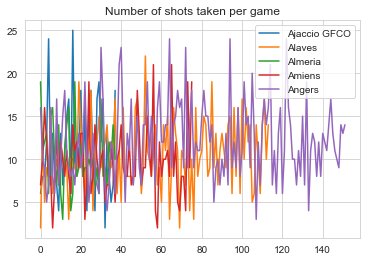

In [24]:
# series of np arrays where each array is a team's ordered list of games
all_games = df_arma.sort_values(['team', 'date'])\
    .groupby('team')\
    ['shots']\
    .apply(lambda s: np.concatenate([s])) 

for i in range(5):
    plt.plot(all_games.iloc[i], label=all_games.index.values[i])

plt.legend()
plt.title('Number of shots taken per game')

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

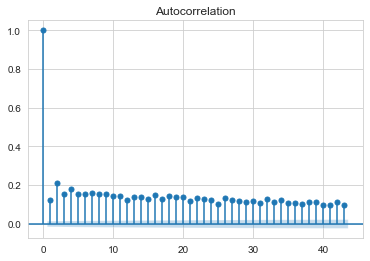

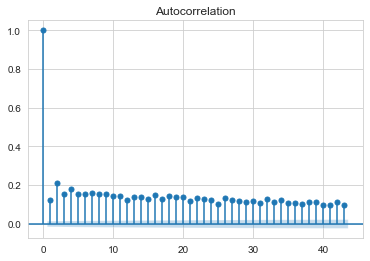

In [26]:
plot_acf(df_arma.sort_values(['team', 'date'])['shots'])

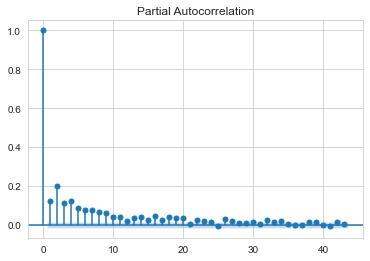

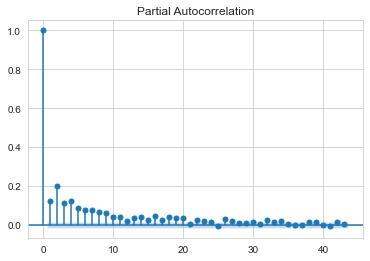

In [27]:
plot_pacf(df_arma.sort_values(['team', 'date'])['shots'])

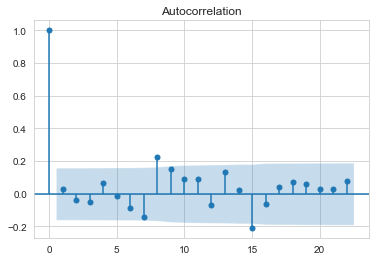

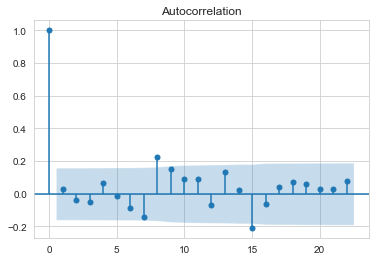

In [28]:
plot_acf(all_games.iloc[i])

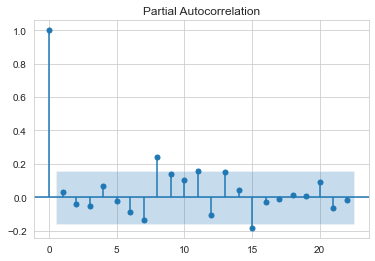

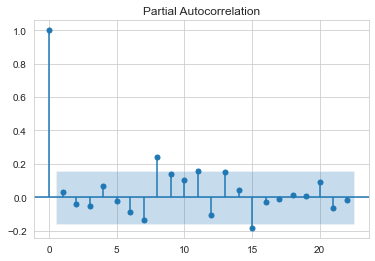

In [29]:
plot_pacf(all_games.iloc[i])

# PageRank
https://www.geeksforgeeks.org/page-rank-algorithm-implementation/

In [30]:
from scipy import sparse
from fast_pagerank import pagerank
from fast_pagerank import pagerank_power

In [31]:
def train_pagerank(edges):
    edges['weight'] = np.where(edges['outcome'] == -1, 3, 
                      np.where(edges['outcome'] == 0, 1, 0))
    A = edges[['team_id', 'opposing_team_id']].values
    weights = edges['weight'].values
    
    n_teams = edges['team_id'].max()
    #my ID's are 1-indexed while nodes are 0-indexed
    G = sparse.csr_matrix((weights, (A[:,0], A[:,1])), shape=(n_teams + 1, n_teams + 1)) 
    pr = pd.Series(pagerank(G, p=0.85))
    
    pagerank_df = pr.rename('pagerank_score').reset_index().rename({'index':'team_id'}, axis=1)\
        .sort_values(['pagerank_score', 'team_id'])
    return pagerank_df

In [32]:
edges_16 = data[['team_id', 'opposing_team_id', 'outcome', 'date']].copy()
edges_16 = edges_16[(edges_16['date'] < '2017-01-01') & (edges_16['outcome'] <= 0)]
pagerank_df_16 = train_pagerank(edges_16)

edges_17 = data[['team_id', 'opposing_team_id', 'outcome', 'date']].copy()
edges_17 = edges_17[(edges_17['date'] < '2018-01-01') & (edges_17['outcome'] <= 0)]
pagerank_df_17 = train_pagerank(edges_17)

In [33]:
pagerank_df_16.head(10)

,team_id,pagerank_score
0,0,0.001217
4,4,0.001217
15,15,0.001217
20,20,0.001217
24,24,0.001217
45,45,0.001217
48,48,0.001217
51,51,0.001217
58,58,0.001217
59,59,0.001217


In [34]:
pagerank_df_16.tail(10)

,team_id,pagerank_score
110,110,0.013179
75,75,0.013217
85,85,0.013282
106,106,0.014039
98,98,0.015114
14,14,0.015145
10,10,0.015331
103,103,0.016543
63,63,0.016574
12,12,0.017682


In [35]:
# group by opposing team and calculate sum of their wins
# should be closely aligned with pagerank score ordering
# the top is quite aligned but the bottom is different which IMO is good
raw_win_rate = edges_16\
    .groupby('opposing_team_id')\
    ['outcome']\
    .sum()\
    .reset_index()\
    .sort_values(['outcome', 'opposing_team_id'])
raw_win_rate.head(10)

,opposing_team_id,outcome
10,12,-69
53,63,-69
91,103,-69
86,98,-66
12,14,-65
8,10,-59
69,79,-55
23,28,-54
94,106,-54
4,6,-53


In [36]:
raw_win_rate.tail(10)

,opposing_team_id,outcome
77,87,-5
22,27,-4
29,34,-4
57,67,-4
73,83,-4
25,30,-3
110,124,-3
26,31,-2
83,95,-1
88,100,0


In [37]:
# why does team ID 24, 45, etc. suck so much according to PageRank
# they suck because they do suck or they have no games prior to 2018
data[data['team_id'] == 24][['date', 'opposing_team_id', 'outcome']]\
    .sort_values(['date'])

,date,opposing_team_id,outcome
2452,2018-08-11,19,-1
12176,2018-08-18,90,0
7435,2018-08-25,58,0
588,2018-09-02,6,-1
3468,2018-09-15,28,-1
10345,2018-09-22,79,-1
2793,2018-09-30,21,-1
16179,2018-10-06,122,-1
6057,2018-10-20,48,1
9409,2018-10-27,73,-1


In [38]:
pagerank_df_16.to_sql(name='teams_pagerank_16',
                   schema='sports',
                   con=sql_engine,
                   if_exists='replace',
                   index=False)
pagerank_df_17.to_sql(name='teams_pagerank_17',
                      schema='sports',
                      con=sql_engine,
                      if_exists='replace',
                      index=False)

# Validation Modeling

In [39]:
data = read_sql(con, "SELECT * FROM sports.melted_stats")

In [40]:
data.columns

Index(['div', 'date', 'y', 'fthg', 'ftag', 'hthg', 'htag', 'hs', 'as', 'hst',
       'ast', 'home_xg', 'away_xg', 'game_id', 'homeoraway', 'team',
       'goal_differential', 'team_id', 'opposing_team', 'opposing_team_id',
       'outcome', 'lagged_cumulative_teamwise_needle',
       'lagged_cumulative_goal_differential', 'lagged_cumulative_shots',
       'lagged_target_percent', 'lagged_cumulative_needle', 'games_played',
       'team_pagerank_16', 'opposing_team_pagerank_16', 'team_pagerank_17',
       'opposing_team_pagerank_17', 'label', 'is_home_team'],
      dtype='object')

In [41]:
import xgboost as xgb
boost_train_features = ['is_home_team', 'lagged_cumulative_teamwise_needle',
                  'lagged_cumulative_goal_differential', 'lagged_cumulative_shots',
                  'lagged_target_percent', 'lagged_cumulative_needle', 'games_played']
train = data[data['date'] < '2017-01-01'].sort_values(['game_id'])
val = data[(data['date'] >= '2017-01-01') & (data['date'] < '2018-01-01')]
test = data[data['date'] >= '2018-01-01']

X_train = train[boost_train_features].astype('float')
y_train = train['outcome'] + 1
train_group = train['game_id'].value_counts(sort=False)

X_val = val[boost_train_features].astype('float')
y_val = val['label']

ranker = xgb.XGBRanker(n_estimators=10)
ranker.fit(X_train, y_train, group=train_group)

XGBRanker(base_score=0.5, booster='gbtree', colsample_bylevel=1,
          colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
          importance_type='gain', interaction_constraints='',
          learning_rate=0.300000012, max_delta_step=0, max_depth=6,
          min_child_weight=1, missing=nan, monotone_constraints='()',
          n_estimators=10, n_jobs=16, num_parallel_tree=1, random_state=0,
          reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
          tree_method='exact', validate_parameters=1, verbosity=None)

In [42]:
explainer = shap.TreeExplainer(ranker)

In [43]:
sv = explainer.shap_values(X_train)

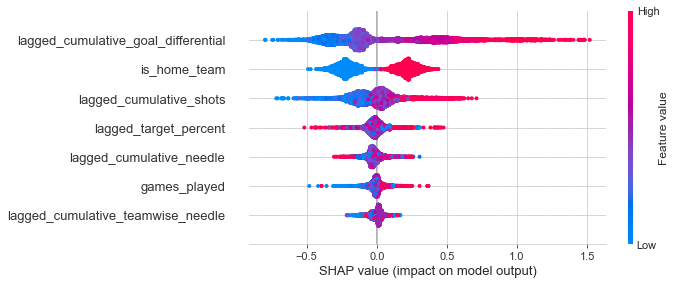

In [44]:
shap.summary_plot(sv, X_train)

In [45]:
val_results = val[['team', 'opposing_team', 'game_id', 'homeoraway', 'label', 'date', 'outcome']].copy()
val_results['pred'] = ranker.predict(X_val)

def sigmoid(x):
    return np.exp(-np.logaddexp(0, -x))
ranker_pred_df = val_results.pivot(index=['date', 'game_id'],
             columns=['homeoraway'],
             values=['team', 'pred'])
ranker_pred_df['pred_ranker'] = sigmoid((ranker_pred_df['pred']['HomeTeam'] - ranker_pred_df['pred']['AwayTeam'])\
                                  .astype('float'))
ranker_pred_df = ranker_pred_df.reset_index()

In [46]:
data_pivoted = data.pivot(index=['date', 'game_id', 'ftag', 'fthg'],
             columns=['homeoraway'],
             values=['team'] + boost_train_features \
                          + ['team_pagerank_16', 'opposing_team_pagerank_16']\
                          + ['team_pagerank_17', 'opposing_team_pagerank_17'])\
    .reset_index()
data_pivoted['label'] = data_pivoted['fthg'] > data_pivoted['ftag']

def diff(df, col):
    return df[col]['HomeTeam'] - df[col]['AwayTeam']
data_pivoted['dlcn'] = diff(data_pivoted, 'lagged_cumulative_needle')
data_pivoted['dpr_16'] = diff(data_pivoted, 'team_pagerank_16')
data_pivoted['dtp'] = diff(data_pivoted, 'lagged_target_percent')
data_pivoted['dcs'] = diff(data_pivoted, 'lagged_cumulative_shots')
data_pivoted['dcgd'] = diff(data_pivoted, 'lagged_cumulative_goal_differential')
data_pivoted['dctn'] = diff(data_pivoted, 'lagged_cumulative_teamwise_needle')
data_pivoted['dgp'] = diff(data_pivoted, 'games_played')

pivoted_features_16 = ['dlcn', 'dpr_16', 'dtp', 'dcs', 'dcgd', 'dctn', 'dgp']
pivoted_train_16 = data_pivoted[data_pivoted['date'] < '2017-01-01']
pivoted_val = data_pivoted[(data_pivoted['date'] >= '2017-01-01') & (data_pivoted['date'] < '2018-01-01')]\
    .copy()

In [47]:
pivoted_val = pd.merge(pivoted_val,
         ranker_pred_df[['game_id', 'pred_ranker']],
         on='game_id',
         how='left')
pivoted_val['pred_ranker'].isnull().sum()

dropping on a non-lexsorted multi-index without a level parameter may impact performance.


0

In [48]:
brier_score_loss(pivoted_val['label'], pivoted_val['pred_ranker'])

0.24527611106188413

In [49]:
X_train = pivoted_train_16[pivoted_features_16].astype('float')
X_train.columns = X_train.columns.droplevel(1)
print('Train features: {}'.format(X_train.columns))
y_train = pivoted_train_16['label'].astype('int')
xgbclassifier = xgb.XGBClassifier(n_estimators=10)
xgbclassifier.fit(X_train, y_train)

Train features: Index(['dlcn', 'dpr_16', 'dtp', 'dcs', 'dcgd', 'dctn', 'dgp'], dtype='object')
[20:21:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [50]:
pivoted_val['pred_xgb'] = xgbclassifier.predict_proba(pivoted_val[pivoted_features_16].astype('float'))[:,1]

In [51]:
brier_score_loss(pivoted_val['label'], pivoted_val['pred_xgb'])

0.22066150788337766

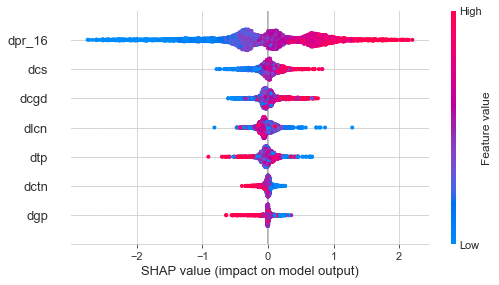

In [52]:
explainer = shap.TreeExplainer(xgbclassifier)
sv = explainer.shap_values(X_train)
shap.summary_plot(sv, X_train)

In [53]:
pivoted_features_16_no_dpr = [i for i in pivoted_features_16 if i not in ['dpr_16']]
X_train = pivoted_train_16[pivoted_features_16_no_dpr].astype('float')
X_train.columns = X_train.columns.droplevel(1)
y_train = pivoted_train_16['label'].astype('int')
xgbclassifier = xgb.XGBClassifier(n_estimators=10)
xgbclassifier.fit(X_train, y_train)
pivoted_val['pred_xgb_no_dpr'] = xgbclassifier.predict_proba(pivoted_val[pivoted_features_16_no_dpr].astype('float'))[:,1]

[20:22:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


In [54]:
brier_score_loss(pivoted_val['label'], pivoted_val['pred_xgb_no_dpr'])

0.2158604896700416

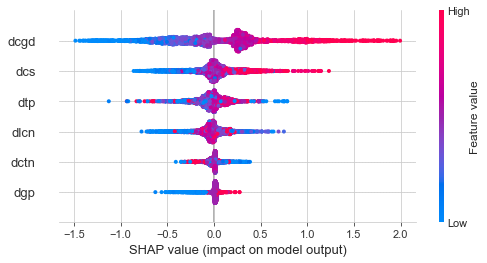

In [55]:
explainer = shap.TreeExplainer(xgbclassifier)
sv = explainer.shap_values(X_train)
shap.summary_plot(sv, X_train)

In [56]:
pivoted_val

date game_id ftag fthg            team                  \
homeoraway                                      AwayTeam        HomeTeam   
0           2017-01-01     947    0    2  Crystal Palace         Arsenal   
1           2017-01-01     948    4    1       Tottenham         Watford   
2           2017-01-02     949    0    3     Southampton         Everton   
3           2017-01-02     950    1    2         Burnley        Man City   
4           2017-01-02     951    0    0       Leicester   Middlesbrough   
...                ...     ...  ...  ...             ...             ...   
1873        2017-12-30    8512    0    2            Spal       Sampdoria   
1874        2017-12-30    8513    0    0           Genoa          Torino   
1875        2017-12-30    8514    3    1        Juventus          Verona   
1876        2017-12-31    1346    0    0        Man City  Crystal Palace   
1877        2017-12-31    1347    1    1         Arsenal       West Brom   

           is_home_team          lagged_cumulative_teamwise_needle            \
homeoraway     AwayTeam HomeTeam                          AwayTeam  HomeTeam   
0                     0        1                             -0.75      0.75   
1                     0        1                               1.0      -1.0   
2                     0        1                               0.0       0.0   
3                     0        1                               0.0       0.0   
4                     0        1                               0.0       0.0   
...                 ...      ...                               ...       ...   
1873                  0        1                               0.0       0.0   
1874                  0        1                          0.166667 -0.166667   
1875                  0        1                              0.25     -0.25   
1876                  0        1                          0.714286 -0.714286   
1877                  0        1                          0.428571 -0.428571   

            ...      dlcn    dpr_16                      dtp  \
homeoraway  ...                                                
0           ...  0.553191  0.004044   0.04031480886604561516   
1           ... -0.422872 -0.006766  -0.03413457590935216356   
2           ... -0.147368 -0.001852   0.02381389754248931791   
3           ...  0.621053  0.007924   0.04063908098755779765   
4           ... -0.347368 -0.007996  -0.03780535470001954270   
...         ...       ...       ...                      ...   
1873        ...  0.310433  0.008103   0.03508587566910774687   
1874        ...  0.121212 -0.000591  -0.00450871518754634909   
1875        ... -0.905384 -0.009462  -0.03711867589636661508   
1876        ... -0.649254  -0.00441  -0.03778997146851675732   
1877        ... -0.522388 -0.003525  -0.06255987372367999983   

                            dcs                     dcgd      dctn  dgp  \
homeoraway                                                                
0            3.4042553191489362   1.10638297872340425532       1.5    0   
1           -4.7237841945288754  -0.94908814589665653495      -2.0  -38   
2           -0.8947368421052631  -0.33684210526315789474       0.0    0   
3            6.1192982456140350   1.55789473684210526316       0.0   38   
4           -3.4736842105263158  -0.43157894736842105263       0.0  -76   
...                         ...                      ...       ...  ...   
1873         2.2871077184054283   0.61323155216284987278       0.0  113   
1874         1.5227272727272727   0.18181818181818181818 -0.333333    0   
1875        -3.9763056092843327  -2.07479045776918113404      -0.5  -38   
1876        -5.0149253731343283  -1.55223880597014930149 -1.428571    0   
1877        -5.2985074626865671  -1.17164179104477611940 -0.857143    0   

           pred_ranker  pred_xgb pred_xgb_no_dpr  
homeoraway                                        
0             0.849824  0.676245        0.774878  
1             0.355041  0.

In [57]:
pivoted_val['pred_pagerank'] = pivoted_val['team_pagerank_16']['HomeTeam'] / \
    (pivoted_val['team_pagerank_16']['HomeTeam'] + pivoted_val['team_pagerank_16']['AwayTeam'])
brier_score_loss(pivoted_val['label'], pivoted_val['pred_pagerank'])

0.22980633733769174

In [58]:
pivoted_val['pred_ensemble_1'] = (pivoted_val['pred_pagerank'] + pivoted_val['pred_xgb_no_dpr']) / 2
brier_score_loss(pivoted_val['label'], pivoted_val['pred_ensemble_1'])

0.21759848791797948

In [59]:
lr = LogisticRegression().fit(X_train, y_train)

In [60]:
pivoted_val['pred_lr'] = lr.predict_proba(pivoted_val[pivoted_features_16_no_dpr].astype('float'))[:,1]

In [61]:
brier_score_loss(pivoted_val['label'], pivoted_val['pred_lr'])

0.21106756635183996

In [62]:
pivoted_val['pred_ensemble_2'] = (pivoted_val['pred_pagerank'] + pivoted_val['pred_xgb_no_dpr'] + pivoted_val['pred_lr']) / 3
brier_score_loss(pivoted_val['label'], pivoted_val['pred_ensemble_2'])

0.2145293773333712

In [63]:
pivoted_val['pred_ensemble_3'] =  (pivoted_val['pred_pagerank'] \
                                   + pivoted_val['pred_xgb_no_dpr'] \
                                   + pivoted_val['pred_lr']\
                                   + pivoted_val['pred_ranker']) / 4
brier_score_loss(pivoted_val['label'], pivoted_val['pred_ensemble_3'])

0.2153240224081198

# Retrain and evaluate on final test set
Although the logistic regression did by far the best on its own, I have a personal bias towards ensembling on modeling homeworks. We'll continue with ensemble 2 as our final model, although I will report scores for each model separately as well. I dropped the ranking model not because I believed it should be removed from the ensemble, but because it was a pain to join back to the rest of the data (since it operates on a different "grain" of data - one row is one team in one game) and its performance wasn't good enough to warrant the extra work.

In [64]:
train = data_pivoted[data_pivoted['date'] < '2018-01-01'].copy()
test = data_pivoted[data_pivoted['date'] >= '2018-01-01'].copy()

features = ['dlcn', 'dtp', 'dcs', 'dcgd', 'dctn', 'dgp']

test['pred_pagerank'] = test['team_pagerank_17']['HomeTeam'] / \
    (test['team_pagerank_17']['HomeTeam'] + test['team_pagerank_17']['AwayTeam'])

# train lr model
lr = LogisticRegression().fit(train[features].astype('float'), train['label'])
test['pred_lr'] = lr.predict_proba(test[features].astype('float'))[:,1]

# train boosting classifier
xgbc = xgb.XGBClassifier(n_estimators=10).fit(train[features].astype('float'), train['label'])
test['pred_xgbc'] = xgbc.predict_proba(test[features].astype('float'))[:,1]

# ensemble predictions
test['pred_ensemble'] = (test['pred_pagerank'] + test['pred_lr'] + test['pred_xgbc']) / 3

[20:22:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


In [65]:
def print_brier(pred_col):
    brier_score = brier_score_loss(test['label'], test[pred_col])
    print('Brier score loss for {} is {}'.format(pred_col, brier_score))
    
print_brier('pred_pagerank')
print_brier('pred_xgbc')
print_brier('pred_lr')
print_brier('pred_ensemble')

Brier score loss for pred_pagerank is 0.2387284329495873
Brier score loss for pred_xgbc is 0.2206957662044385
Brier score loss for pred_lr is 0.21756940227888436
Brier score loss for pred_ensemble is 0.22068628679170915
